## Import here all the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import plotly.express as px
import random
from keras.utils import np_utils
from scipy.stats import multivariate_normal as mvn

import string
import re #regular expressions
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from __future__ import absolute_import, division, print_function, unicode_literals
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_text as text
from official.nlp import optimization

#Import .py file of general algorithms
from general import accuracy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 7.9 MB/s 
     |████████████████████████████████| 92 kB 4.7 MB/s 
     |████████████████████████████████| 48.3 MB 160 kB/s 
     |████████████████████████████████| 1.1 MB 39.5 MB/s 
     |████████████████████████████████| 99 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 32.2 MB/s 
     |████████████████████████████████| 237 kB 68.4 MB/s 
     |████████████████████████████████| 352 kB 36.1 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 


## Load dataset

In [ ]:
def numLabel(data):
  if data == 'commissive' or data == 'directive': #Regular chat
    label = 0
  elif data == 'inform':
    label = 1
  else: #Question
    label = 2

  return label

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_train.drop(['Emotion','Dialogue_ID'], inplace=True, axis=1)
df_train['Dialogue_Act'] = df_train['Dialogue_Act'].apply(numLabel)
df_train.head()

,Utterance,Dialogue_Act
0,"say , jim , how about going for a few beers af...",0
1,you know that is tempting but is really not go...,0
2,what do you mean ? it will help us to relax .,2
3,do you really think so ? i don't . it will jus...,2
4,i guess you are right.but what shall we do ? i...,2


In [ ]:
df_val = pd.read_csv('data/dev.csv')
df_val.drop(['Emotion','Dialogue_ID'], inplace=True, axis=1)
df_val['Dialogue_Act'] = df_val['Dialogue_Act'].apply(numLabel)
df_val.head()

,Utterance,Dialogue_Act
0,"good morning , sir . is there a bank near here ?",2
1,there is one . 5 blocks away from here ?,1
2,"well , that's too far.can you change some mone...",0
3,"surely , of course . what kind of currency hav...",2
4,rib .,1


In [ ]:
df_test = pd.read_csv('data/test.csv')
df_test.drop(['Emotion','Dialogue_ID'], inplace=True, axis=1)
df_test['Dialogue_Act'] = df_test['Dialogue_Act'].apply(numLabel)
df_test.head()

,Utterance,Dialogue_Act
0,"hey man , you wanna buy some weed ?",0
1,some what ?,2
2,"weed ! you know ? pot , ganja , mary jane some...",0
3,"oh , umm , no thanks .",0
4,i also have blow if you prefer to do a few lin...,0


In [ ]:
#Check the size of the data
print(f"Size of training set: {df_train.shape}")
print(f"Size of validation set: {df_val.shape}")
print(f"Size of test set: {df_test.shape}\n")

#Check and delete for duplicates
print(f"Number of duplicate rows in training: {df_train[df_train.duplicated()].shape}")
df_train.drop_duplicates(subset=None, keep="first", inplace=True)
print(f"Number of duplicate rows in validation: {df_val[df_val.duplicated()].shape}")
df_val.drop_duplicates(subset=None, keep="first", inplace=True)
print(f"Number of duplicate rows in test: {df_test[df_test.duplicated()].shape}\n")
df_test.drop_duplicates(subset=None, keep="first", inplace=True)

print(f"Final size of train: {df_train.shape}")
print(f"Final size of validation: {df_val.shape}")
print(f"Final size of test: {df_test.shape}")

df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

Size of training set: (87170, 2)
Size of validation set: (8069, 2)
Size of test set: (7740, 2)

Number of duplicate rows in training: (14779, 2)
Number of duplicate rows in validation: (387, 2)
Number of duplicate rows in test: (271, 2)

Final size of train: (72391, 2)
Final size of validation: (7682, 2)
Final size of test: (7469, 2)


## Data Preprocessing

In [ ]:
def preprocess(sentence,lemma=True):
  #Remove url links
  proc_sent = re.sub(r'https?:\/\/.*[\r\n]*','',sentence)

  #Delete non-ASCII values
  proc_sent = str(proc_sent.encode("ascii","ignore"))[1:]

  #Remove punctuation
  proc_sent = ''.join([char for char in proc_sent if char not in string.punctuation])

  #Parse to lower case
  proc_sent = proc_sent.lower()

  #Tokenize and remove stop words
  stop_words = stopwords.words('english')
  proc_sent = word_tokenize(proc_sent) #serves to separate each word as a unique element
  proc_sent = [word for word in proc_sent if word not in stop_words]

  #Remove single letters
  proc_sent = [word for word in proc_sent if len(word) != 1]

  #Stem or lemmatize (just 1)
  if lemma:
    lemmatizer = WordNetLemmatizer()
    proc_sent = [lemmatizer.lemmatize(word) for word in proc_sent]
  else:
    porter = PorterStemmer()
    proc_sent = [porter.stem(word) for word in proc_sent] #Stemming

  return proc_sent

In [ ]:
df_train['Utterance'] = df_train['Utterance'].apply(preprocess)
print(f"{len(df_train)} train observations...")
df_val['Utterance'] = df_val['Utterance'].apply(preprocess)
print(f"{len(df_val)} validation observations...")
df_test['Utterance'] = df_test['Utterance'].apply(preprocess)
print(f"{len(df_test)} test observations...")

72391 train observations...
7682 validation observations...
7469 test observations...


In [ ]:
df_train.drop('index', inplace = True, axis = 1)
df_val.drop('index', inplace = True, axis = 1)
df_test.drop('index', inplace = True, axis = 1)

Text(0.5, 1.0, 'Sentences by class')

<Figure size 432x288 with 0 Axes>

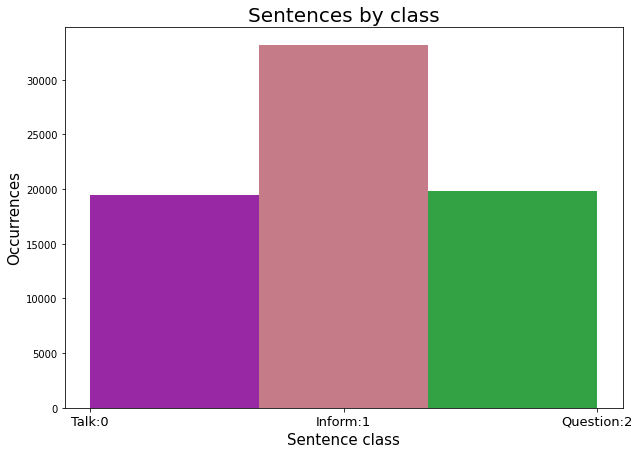

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(df_train['Dialogue_Act'], bins=3)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Talk:0','Inform:1','Question:2'], size=13)
for i in range(len(N)):
  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

plt.ylabel("Occurrences", size=15)
plt.xlabel("Sentence class", size=15)
plt.title("Sentences by class", size=20)

Text(0.5, 1.0, "Analysis of sentence's length")

<Figure size 432x288 with 0 Axes>

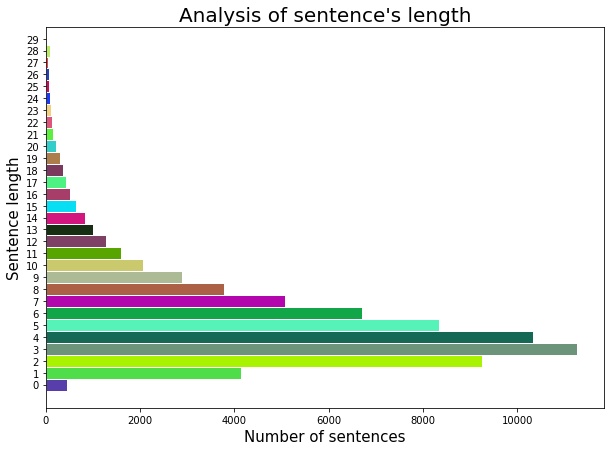

In [ ]:
lengths = [len(i) for i in df_train['Utterance']]
uniques = np.unique(lengths)
bins = [i for i in range(30)]

plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(lengths, bins=bins, orientation='horizontal', edgecolor='white', linewidth=1, align='left')
ax.set_yticks(np.arange(30))
# ax.set_yticklabels(uniques, size=10)
for i in range(len(N)):
  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

plt.ylabel("Sentence length", size=15)
plt.xlabel("Number of sentences", size=15)
plt.title("Analysis of sentence's length", size=20)

In [ ]:
# #Remove short sentences
#size = int(np.mean(np.arange(2,16)))

#for i in range(len(df_train['Utterance'])):
  #Save as is if the size is between the margins
  #Clip the long sentences to make them shorter
#  if len(df_train['Utterance'][i]) > 16:
#    df_train['Utterance'][i] = df_train['Utterance'][i][:size]
#  elif len(df_train['Utterance'][i]) < 2:
   # df_train.drop([i], axis=0, inplace=True)

#df_train = df_train.reset_index()
#print(f"{len(df_train)} observations...")
#print(f"Mean size for clipping sentences: {size}")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  53  54  55
  58  60  61  62  64  67  72  74  76  93  97  98 117]


Text(0.5, 1.0, 'Analysis of stemmed sentences')

<Figure size 432x288 with 0 Axes>

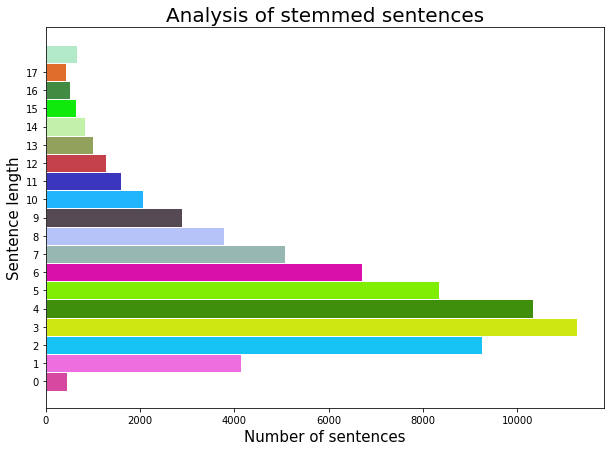

In [ ]:
lengths = [len(i) for i in df_train['Utterance']]
uniques = np.unique(lengths)
print(uniques)
bins = [i for i in range(20)]

plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(lengths, bins=bins, orientation='horizontal', edgecolor='white', linewidth=1, align='left')
ax.set_yticks(np.arange(18))
for i in range(len(N)):
  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

plt.ylabel("Sentence length", size=15)
plt.xlabel("Number of sentences", size=15)
plt.title("Analysis of stemmed sentences", size=20)

In [ ]:
def pd_to_tensor_data (data):
  new_tensor_data = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(data["Utterance"].values, tf.string),
        tf.cast(data["Dialogue_Act"].values, tf.int64)
        )
  ).batch(1)  ##For the requeriments for the Albert model, we do this because we need to indtroduce the data like tensors
  return new_tensor_data      

In [ ]:
df_train['Utterance']

0                          [say, jim, going, beer, dinner]
1                  [know, tempting, really, good, fitness]
2                                   [mean, help, u, relax]
3        [really, think, dont, make, u, fat, act, silly...
4        [guess, rightbut, shall, dont, feel, like, sit...
                               ...                        
72386                                  [want, pair, locus]
72387                   [take, look, one, display, please]
72388                                     [need, size, 41]
72389                               [could, check, please]
72390                                  [okay, ill, minute]
Name: Utterance, Length: 72391, dtype: object

In [ ]:
def join_text (text):
  return " ".join(text)

In [ ]:
df_train['Utterance'] = df_train['Utterance'].apply(join_text)
df_val['Utterance'] = df_val['Utterance'].apply(join_text)
df_test['Utterance'] = df_test['Utterance'].apply(join_text)

In [ ]:
df_train['Utterance']

0                                say jim going beer dinner
1                        know tempting really good fitness
2                                        mean help u relax
3        really think dont make u fat act silly remembe...
4         guess rightbut shall dont feel like sitting home
                               ...                        
72386                                      want pair locus
72387                         take look one display please
72388                                         need size 41
72389                                   could check please
72390                                      okay ill minute
Name: Utterance, Length: 72391, dtype: object

In [ ]:
tensor_train = pd_to_tensor_data(df_train)
tensor_validation = pd_to_tensor_data(df_val)
tensor_test = pd_to_tensor_data(df_test)

## Model Creation

Create the embeddings

In [ ]:
# embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
# hub_layer = hub.KerasLayer(embedding,
#                            input_shape=[],
#                            dtype=tf.string,
#                            trainable=True)

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'    ## To use the albert model, this meanas that you are gonna use the encoder ofthe albert model
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'      ## its the embbeder tha iam gonna use to convert the words in vectors
                                                                                      ## embeddin is transform the words into vector in order to be able to run a model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(),
                                     dtype=tf.string,
                                     name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, # turn the words into vectors
                                       name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder,   ## call the model albert 
                           trainable=False, #leave the original weights 
                           name = 'BERT_encoder')
  outputs = encoder(encoder_inputs)  #running the preddictions with Albert
  net = outputs['pooled_output']  
  net = tf.keras.layers.Dropout(0.1)(net)   ## turn off the 10 percentage of the neurons
  net = tf.keras.layers.Dense(3,
                              activation = 'softmax',
                              name = 'classifier') (net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
epochs = 7
steps_per_epoch = tf.data.experimental.cardinality(tensor_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics = metrics)

In [ ]:
history = classifier_model.fit(x=tensor_train,
                               validation_data=tensor_validation,
                               epochs=epochs)

Epoch 1/7
72391/72391 [==============================] - 1235s 17ms/step - loss: 0.9036 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.8999 - val_sparse_categorical_accuracy: 0.6854
Epoch 2/7
72391/72391 [==============================] - 1237s 17ms/step - loss: 0.9099 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.8835 - val_sparse_categorical_accuracy: 0.6898
Epoch 3/7
72391/72391 [==============================] - 1242s 17ms/step - loss: 0.9051 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.8865 - val_sparse_categorical_accuracy: 0.6902
Epoch 4/7
72391/72391 [==============================] - 1232s 17ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.8835 - val_sparse_categorical_accuracy: 0.6919
Epoch 5/7
72391/72391 [==============================] - 1232s 17ms/step - loss: 0.9004 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.8805 - val_sparse_categorical_accuracy: 0.6933
Epoch 6/7
72391/72391 [==============================] - 1233s 17

In [ ]:
loss, accuracy = classifier_model.evaluate(df_test)
print(f"Loss: {loss} and Accuracy: {accuracy}")

In [ ]:
history.keys()

In [ ]:
# history_dict = history.history
# print(history_dict.keys())

# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
# fig = plt.figure(figsize=(10, 6))
# fig.tight_layout()

# plt.subplot(2, 1, 1)
# # r is for "solid red line"
# plt.plot(epochs, loss, 'r', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# # plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

In [ ]:
dataset_name = 'silicone_dyda'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
# model = keras.Sequential()
# model.add(hub_layer)  #Embedding layer
# model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(.2))
# model.add(keras.layers.Dense(512, activation='tanh'))
# model.add(keras.layers.Dropout(.2))
# model.add(keras.layers.Dense(512, activation='relu'))
# model.add(keras.layers.Dropout(.2))
# model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dropout(.2))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dropout(.1))
# model.add(keras.layers.Dense(20, activation='relu'))
# model.add(keras.layers.Dropout(.2))
# model.add(keras.layers.Dense(3, activation='softmax'))
# model.summary()

In [ ]:
# model.compile(optimizer = 'Nadam',
#               loss = keras.losses.SparseCategoricalCrossentropy(),
#               metrics = ['accuracy'])

In [ ]:
# history = model.fit(tensor_train.shuffle(10000).batch(512),
#                     epochs = 100,
#                     validation_data = tensor_validation.batch(512),
#                     verbose = 1)

In [ ]:
# plt.figure(figsize=(10,7))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.figure(figsize=(10,7))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

https://huggingface.co/datasets/silicone

https://huggingface.co/datasets/silicone/tree/main/dummy/dyda_da/1.0.0